# Rice Disease Detection

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Bidirectional, LSTM, Reshape, Dropout, MultiHeadAttention
from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

import seaborn as sb
from sklearn.metrics import confusion_matrix

## Allocate memory and environment to GPU

In [5]:
phy_devices = tf.config.experimental.list_physical_devices('GPU')
print(phy_devices)
if phy_devices:
    print("Memory allocation and computations pushed to GPU env")
    tf.config.experimental.set_memory_growth(phy_devices[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Memory allocation and computations pushed to GPU env


## Data extraction and augmentation

In [4]:
#dataset path
dataset_dir = 'D:/Andrei/Andrei/Prog Applications/datasets'
dataset_name = '/_Preprocessed_Rice diseases exclusively_with_valid'
dataset_dir = dataset_dir + dataset_name

#image details
size = (224, 224)
img_color_mode = 'rgb'
img_type = '.jpg'

In [5]:
class_names=['blast','blight','tungro']

In [6]:
N=[]
for i in range(len(class_names)):
    N+=[i]
    
normal_mapping=dict(zip(class_names,N)) 
reverse_mapping=dict(zip(N,class_names)) 

def mapper(value):
    return reverse_mapping[value]

## Data Retrieval Functions

In [7]:
def get_trainXY_and_validXY(train_path, valid_path, size=(224,224), batch_size=1):
    train_batch = tf.keras.utils.image_dataset_from_directory(
        directory=train_path, 
        image_size=size,
        labels='inferred',
        label_mode='categorical',
        shuffle=True,
        batch_size=batch_size,
        seed = 9
    )
    
    valid_batch = tf.keras.utils.image_dataset_from_directory(
        directory=valid_path, 
        image_size=size, 
        labels='inferred',
        label_mode='categorical',
        batch_size=batch_size,
        shuffle=True,
        seed = 9
    )
    
    X = []
    Y = []
    for images, labels in train_batch.take(-1):
        X.append(images.numpy()[0,:,:,:])
        Y.append(labels.numpy()[0])
    vX = []
    vY = []
    for images, labels in valid_batch.take(-1):
        vX.append(images.numpy()[0,:,:,:])
        vY.append(labels.numpy()[0])
        
    return np.array(X), np.array(Y), np.array(vX), np.array(vY)


def get_testXYbatch(test_path, size=(224,224), batch_size=1):
    test_batch = tf.keras.utils.image_dataset_from_directory(
        directory=test_path, 
        image_size=size, 
        labels='inferred',
        label_mode='categorical',
        batch_size=batch_size,
    )

    X = []
    Y = []
    for images, labels in test_batch.take(-1):
        X.append(images.numpy()[0,:,:,:])
        Y.append(labels.numpy()[0])
    return np.array(X), np.array(Y), test_batch

In [8]:
trainx, trainy, validx, validy = get_trainXY_and_validXY(f'{dataset_dir}/training', f'{dataset_dir}/validation')
testx, testy, testbatch = get_testXYbatch(f'{dataset_dir}/testing')

Found 1200 files belonging to 3 classes.
Found 48 files belonging to 3 classes.
Found 48 files belonging to 3 classes.


In [9]:
# normalize/standardize dataset
trainx /= 255
validx /= 255
testx /= 255

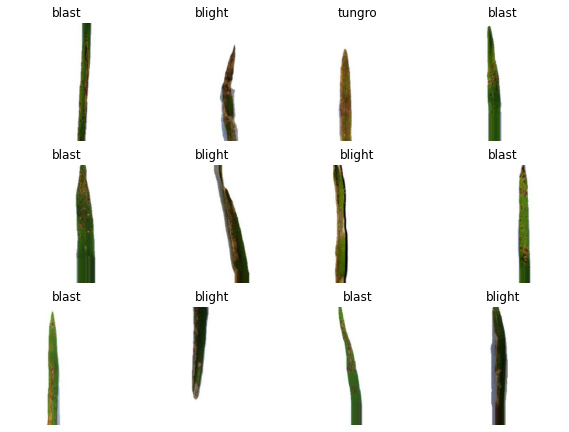

In [12]:
plt.figure(figsize=(10, 10))
for i in range(12):
    ax = plt.subplot(4, 4, i + 1)
    image = trainx[i] 
    plt.imshow(image.astype("uint8"))
    plt.title(class_names[np.argmax(trainy[i], axis=-1)])
    plt.axis("off")

In [9]:
print(f"Training data shape: {trainx.shape}")
print(f"Validation data shape: {validx.shape}")
print(f"Testing data shape: {testx.shape}")
print(f"Classifications: {len(class_names)}, {class_names}")

Training data shape: (1200, 224, 224, 3)
Validation data shape: (48, 224, 224, 3)
Testing data shape: (48, 224, 224, 3)
Classifications: 3, ['blast', 'blight', 'tungro']


### Custom Layers

In [10]:
def ReshapeLayer(x):
    shape = x.shape
    reshape = Reshape((shape[1],shape[2]*shape[3]))(x)
    return reshape

def BiLSTMLayer(x, neurons=128):
    # Tanh Activation provides access of the LSTM to the cuDNN which provides faster computation
    return Bidirectional(LSTM(neurons, activation='tanh', recurrent_dropout=0))(x)

def AttentionLayer(x, heads = 1, dim = 1, training = False):
    return MultiHeadAttention(num_heads=heads, key_dim=dim)(x, x, training=training)

# Models

In [16]:
def DenseBilstm(attention=False):
    cnn = tf.keras.applications.DenseNet201(
        input_shape=(size[0],size[1],3),
        include_top=False,
        weights='imagenet'
    )
    cnn.trainable = False
    
    #Model Sequence
    images = cnn.input
    x = cnn.output
    if attention:
        x = AttentionLayer(x, heads = 2, dim = 2, training = True)
    x = ReshapeLayer(x)
    x = BiLSTMLayer(x, 128)
    pred = Dense(3, activation='softmax')(x)
        
    model = tf.keras.Model(inputs=images, outputs=pred)
    model.compile(
        tf.keras.optimizers.Adam(learning_rate=0.0001), 
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [17]:
def MoBilstm(attention=False):
    cnn = tf.keras.applications.MobileNet(
        input_shape=(size[0],size[1],3),
        include_top=False,
        weights='imagenet'
    )
    cnn.trainable = False
    
    #Model Sequence
    images = cnn.input
    x = cnn.output
    if attention:
        x = AttentionLayer(x, heads = 2, dim = 2, training = True)
    x = ReshapeLayer(x)
    x = BiLSTMLayer(x, 128)
    pred = Dense(3, activation='softmax')(x)
    
    model = tf.keras.Model(inputs=images, outputs=pred)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
        loss='categorical_crossentropy', 
        metrics=['accuracy']
    )
    return model

# Training

In [18]:
model_label = 'mnet_bilstm_sample1'

# set early stopping criteria
pat = 5 # this is the number of epochs with no improvment after which the training will stop
early_stopping = EarlyStopping(monitor='val_loss', patience=pat, verbose=1, baseline=None)

# to save the history of models
csv_logger = CSVLogger(f'logs/{model_label}.log', separator=",", append=True)

# define the model checkpoint callback -> this will keep on saving the model as a physical file
def ModelCheckPointCB(model_label = 'mnet_bilstm_sample1', save_best_only=True):
    return ModelCheckpoint(
        f'model_checkpoints/{model_label}.h5', 
        verbose=1, save_best_only=save_best_only
    )

In [19]:
model1 = DenseBilstm(attention = False)
model1.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [26]:
# model 1, DenseBiLSTM_noAttention
model_label = "DenseBiLSTM_noAttention"
history1 = model1.fit(
        x = ImageDataGenerator().flow(trainx, trainy, batch_size=16),
        validation_data = ImageDataGenerator().flow(validx, validy, batch_size=16),
        batch_size=32,
        epochs=50,
        callbacks=[early_stopping, ModelCheckPointCB(model_label), csv_logger],
        verbose=1,            
    )

Epoch 1/50
75/75 [==============================] - 27s 235ms/step - loss: 0.3957 - accuracy: 0.8492 - val_loss: 0.3239 - val_accuracy: 0.8542

Epoch 00001: val_loss improved from inf to 0.32387, saving model to model_checkpoints\DenseBiLSTM_noAttention.h5
Epoch 2/50
75/75 [==============================] - 12s 161ms/step - loss: 0.0529 - accuracy: 0.9958 - val_loss: 0.2487 - val_accuracy: 0.8750

Epoch 00002: val_loss improved from 0.32387 to 0.24869, saving model to model_checkpoints\DenseBiLSTM_noAttention.h5
Epoch 3/50
75/75 [==============================] - 12s 161ms/step - loss: 0.0124 - accuracy: 1.0000 - val_loss: 0.2252 - val_accuracy: 0.8958

Epoch 00003: val_loss improved from 0.24869 to 0.22518, saving model to model_checkpoints\DenseBiLSTM_noAttention.h5
Epoch 4/50
75/75 [==============================] - 12s 162ms/step - loss: 0.0049 - accuracy: 1.0000 - val_loss: 0.1971 - val_accuracy: 0.8958

Epoch 00004: val_loss improved from 0.22518 to 0.19713, saving model to model

Epoch 35/50
75/75 [==============================] - 14s 186ms/step - loss: 4.7500e-05 - accuracy: 1.0000 - val_loss: 0.1374 - val_accuracy: 0.9583

Epoch 00035: val_loss improved from 0.13850 to 0.13745, saving model to model_checkpoints\DenseBiLSTM_noAttention.h5
Epoch 36/50
75/75 [==============================] - 13s 178ms/step - loss: 4.4306e-05 - accuracy: 1.0000 - val_loss: 0.1398 - val_accuracy: 0.9583

Epoch 00036: val_loss did not improve from 0.13745
Epoch 37/50
75/75 [==============================] - 14s 190ms/step - loss: 4.1680e-05 - accuracy: 1.0000 - val_loss: 0.1381 - val_accuracy: 0.9583

Epoch 00037: val_loss did not improve from 0.13745
Epoch 38/50
75/75 [==============================] - 16s 207ms/step - loss: 3.8903e-05 - accuracy: 1.0000 - val_loss: 0.1365 - val_accuracy: 0.9583

Epoch 00038: val_loss improved from 0.13745 to 0.13647, saving model to model_checkpoints\DenseBiLSTM_noAttention.h5
Epoch 39/50
75/75 [==============================] - 14s 193ms/step 

In [68]:
# model 2, MoBiLSTM_noAttention
model2 = MoBilstm(attention = False)
model2.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0  

In [69]:
model_label2 = "MoBiLSTM_noAttention"
history2 = model2.fit(
        x = ImageDataGenerator().flow(trainx,trainy,batch_size=16),
        validation_data = ImageDataGenerator().flow(validx, validy, batch_size=16),
        batch_size=32,
        epochs=50,
        callbacks=[early_stopping, ModelCheckPointCB(model_label2), csv_logger],
        verbose=1,            
    )

Epoch 1/50
75/75 [==============================] - 12s 94ms/step - loss: 0.4625 - accuracy: 0.8242 - val_loss: 0.4409 - val_accuracy: 0.8333

Epoch 00001: val_loss improved from inf to 0.44086, saving model to model_checkpoints\MoBiLSTM_noAttention.h5
Epoch 2/50
75/75 [==============================] - 4s 50ms/step - loss: 0.1411 - accuracy: 0.9575 - val_loss: 0.3295 - val_accuracy: 0.8750

Epoch 00002: val_loss improved from 0.44086 to 0.32949, saving model to model_checkpoints\MoBiLSTM_noAttention.h5
Epoch 3/50
75/75 [==============================] - 4s 51ms/step - loss: 0.0443 - accuracy: 0.9950 - val_loss: 0.3175 - val_accuracy: 0.8958

Epoch 00003: val_loss improved from 0.32949 to 0.31745, saving model to model_checkpoints\MoBiLSTM_noAttention.h5
Epoch 4/50
75/75 [==============================] - 4s 51ms/step - loss: 0.0126 - accuracy: 1.0000 - val_loss: 0.3373 - val_accuracy: 0.8958

Epoch 00004: val_loss did not improve from 0.31745
Epoch 5/50
75/75 [========================

# Data Presentation

### DenseBiLSTM

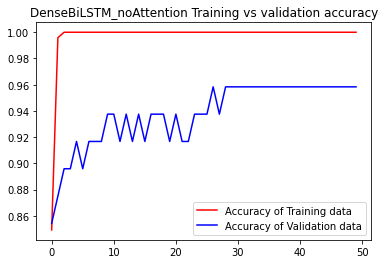

<Figure size 432x288 with 0 Axes>

In [27]:
get_acc = history1.history['accuracy']
value_acc = history1.history['val_accuracy']
get_loss = history1.history['loss']
validation_loss = history1.history['val_loss']

epochs = range(len(get_acc))
plt.plot(epochs, get_acc, 'r', label='Accuracy of Training data')
plt.plot(epochs, value_acc, 'b', label='Accuracy of Validation data')
plt.title(f'{model_label} Training vs validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

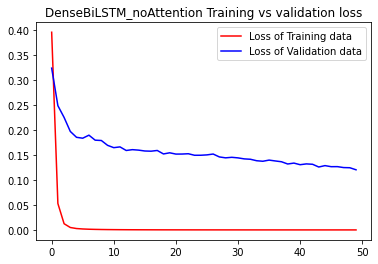

<Figure size 432x288 with 0 Axes>

In [28]:
epochs = range(len(get_loss))
plt.plot(epochs, get_loss, 'r', label='Loss of Training data')
plt.plot(epochs, validation_loss, 'b', label='Loss of Validation data')
plt.title(f'{model_label} Training vs validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

[Text(0, 0.5, 'blast'), Text(0, 1.5, 'blight'), Text(0, 2.5, 'tungro')]

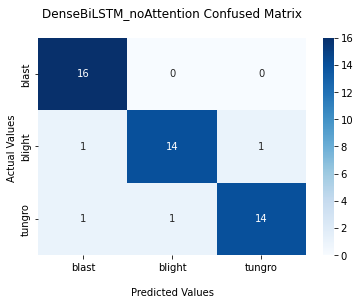

In [29]:
y_pred=model1.predict(testx)
pred=np.argmax(y_pred,axis=1)
ground = np.argmax(testy,axis=1)

conf_matrix = confusion_matrix(ground, pred)
ax = sb.heatmap(conf_matrix, annot=True, cmap='Blues')
ax.set_title(f'{model_label} Confused Matrix\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)

In [30]:
print(classification_report(ground,pred))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94        16
           1       0.93      0.88      0.90        16
           2       0.93      0.88      0.90        16

    accuracy                           0.92        48
   macro avg       0.92      0.92      0.92        48
weighted avg       0.92      0.92      0.92        48



In [31]:
model1.evaluate(x=ImageDataGenerator().flow(testx, testy, batch_size=32), verbose = 1)

2/2 [==============================] - 0s 149ms/step - loss: 0.2106 - accuracy: 0.9167


[0.2106127291917801, 0.9166666865348816]

### MoBiLSTM

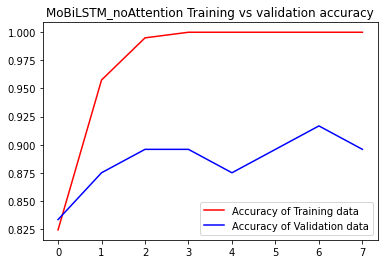

<Figure size 432x288 with 0 Axes>

In [76]:
get_acc = history2.history['accuracy']
value_acc = history2.history['val_accuracy']
get_loss = history2.history['loss']
validation_loss = history2.history['val_loss']

epochs = range(len(get_acc))
plt.plot(epochs, get_acc, 'r', label='Accuracy of Training data')
plt.plot(epochs, value_acc, 'b', label='Accuracy of Validation data')
plt.title(f'{model_label2} Training vs validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

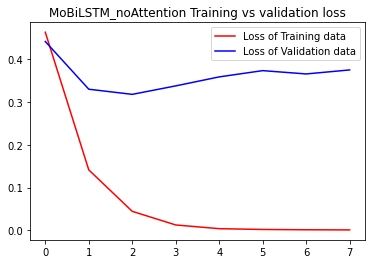

<Figure size 432x288 with 0 Axes>

In [77]:
epochs = range(len(get_loss))
plt.plot(epochs, get_loss, 'r', label='Loss of Training data')
plt.plot(epochs, validation_loss, 'b', label='Loss of Validation data')
plt.title(f'{model_label2} Training vs validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

[Text(0, 0.5, 'blast'), Text(0, 1.5, 'blight'), Text(0, 2.5, 'tungro')]

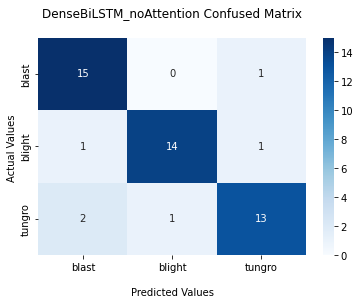

In [78]:
y_pred=model2.predict(testx)
pred=np.argmax(y_pred,axis=1)
ground = np.argmax(testy,axis=1)

conf_matrix = confusion_matrix(ground, pred)
ax = sb.heatmap(conf_matrix, annot=True, cmap='Blues')
ax.set_title(f'{model_label} Confused Matrix\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)

In [79]:
print(classification_report(ground,pred))

              precision    recall  f1-score   support

           0       0.83      0.94      0.88        16
           1       0.93      0.88      0.90        16
           2       0.87      0.81      0.84        16

    accuracy                           0.88        48
   macro avg       0.88      0.88      0.87        48
weighted avg       0.88      0.88      0.87        48



In [80]:
model2.evaluate(x=ImageDataGenerator().flow(testx, testy, batch_size=32), verbose = 1)

2/2 [==============================] - 0s 44ms/step - loss: 0.4896 - accuracy: 0.8750


[0.48961886763572693, 0.875]

### Single Prediction

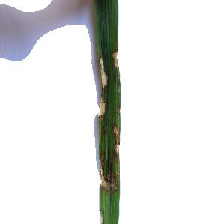

In [11]:
# image = load_img(f"{dataset_dir}/blight/IMG_1034.jpg",target_size=(224,224))
image1 = load_img(f"{dataset_dir}/testing/blight/_2_7097357.jpg",target_size=(224,224))
image2 = load_img(f"{dataset_dir}/testing/tungro/_2_9149343.jpg",target_size=(224,224))
image3 = load_img(f"{dataset_dir}/testing/blast/_3_5086811.jpg",target_size=(224,224))

image4 = load_img(f"{dataset_dir}/testing/blight/_11_5010550.jpg",target_size=(224,224))
image5 = load_img(f"{dataset_dir}/testing/tungro/_14_4884708.jpg",target_size=(224,224))
image6 = load_img(f"{dataset_dir}/testing/blast/_10_4011363.jpg",target_size=(224,224))
image1

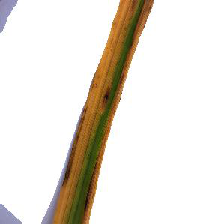

In [13]:
image2

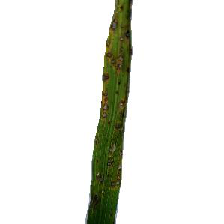

In [14]:
image3

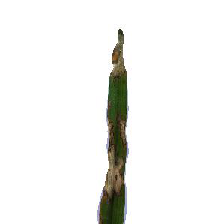

In [15]:
image4

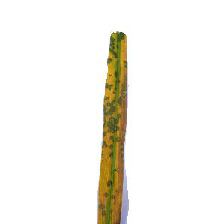

In [16]:
image5

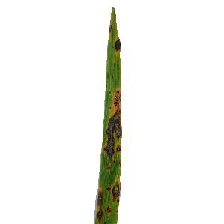

In [17]:
image6

In [2]:
saved_model_file_path = 'model_checkpoints/'
saved_model_file_name = "DenseBiLSTM_noAttention"
saved_model = tf.keras.models.load_model(saved_model_file_path + saved_model_file_name + '.h5')

In [3]:
saved_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
image=img_to_array(image1) 
image=image/255.0
prediction_image=np.array(image)
prediction_image= np.expand_dims(image, axis=0)

prediction=saved_model.predict(prediction_image)
value=np.argmax(prediction)
move_name=mapper(value)
#print(prediction)
#print(value)
print("Prediction is {}.".format(move_name))

[Text(0, 0.5, 'blast'), Text(0, 1.5, 'blight'), Text(0, 2.5, 'tungro')]

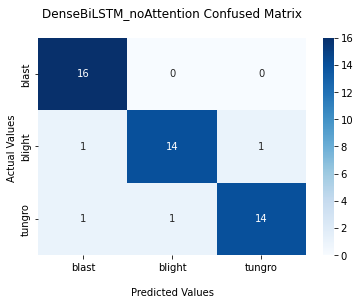

In [33]:
y_pred=saved_model.predict(testx)
pred=np.argmax(y_pred,axis=1)
ground = np.argmax(testy,axis=1)

conf_matrix = confusion_matrix(ground, pred)
ax = sb.heatmap(conf_matrix, annot=True, cmap='Blues')
ax.set_title(f'{saved_model_file_name} Confused Matrix\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)

In [25]:
print(classification_report(ground,pred))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94        16
           1       0.93      0.88      0.90        16
           2       0.93      0.88      0.90        16

    accuracy                           0.92        48
   macro avg       0.92      0.92      0.92        48
weighted avg       0.92      0.92      0.92        48



In [34]:
saved_model.evaluate(x=ImageDataGenerator().flow(testx, testy, batch_size=32), verbose = 1)

2/2 [==============================] - 1s 175ms/step - loss: 0.2106 - accuracy: 0.9167


[0.21061231195926666, 0.9166666865348816]